In [1]:
%pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

Note: you may need to restart the kernel to use updated packages.


In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [5]:
keyfile = Path.home() / '.azure' / 'fastai-bing.key'
with open(keyfile) as f:
    key = f.readline().strip()

In [8]:
results = search_images_bing(key, 'grizzley bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [9]:
dest = 'images/grizzley.jpg'
download_url(ims[0], dest)

Path('images/grizzley.jpg')

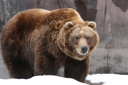

In [10]:
im = Image.open(dest)
im.to_thumb(128, 128)

In [11]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

In [12]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [20]:
fns = get_image_files(path)
fns

(#417) [Path('bears/grizzly/97d20e3e-ae87-4526-ac93-a9325a9b3988.jpg'),Path('bears/grizzly/3ae7276f-5874-4325-8f47-e48713560dd6.jpg'),Path('bears/grizzly/13009bd3-dc3f-4431-b315-2d778b885fd7.jpg'),Path('bears/grizzly/dfb0a13f-17dc-440e-b5f1-1facee421237.jpg'),Path('bears/grizzly/bdcc0554-0271-4081-900e-8e7b97d390c6.jpg'),Path('bears/grizzly/e20ec349-f653-42d0-809b-8f0d592e9b20.jpg'),Path('bears/grizzly/ce3e216a-8106-4907-8cc9-8e46569cc66a.jpg'),Path('bears/grizzly/f71e3ee7-c2c7-49d0-90bc-a5528d5c7fb6.jpg'),Path('bears/grizzly/1102f6e2-1ec0-4139-ba41-8f0aa98a8f46.jpg'),Path('bears/grizzly/6e08a112-4865-4b46-8ac1-eeb3474bcdc8.jpg')...]

In [21]:
failed = verify_images(fns)
failed

(#0) []

In [22]:
failed.map(Path.unlink);

In [23]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [25]:
dls = bears.dataloaders(path)

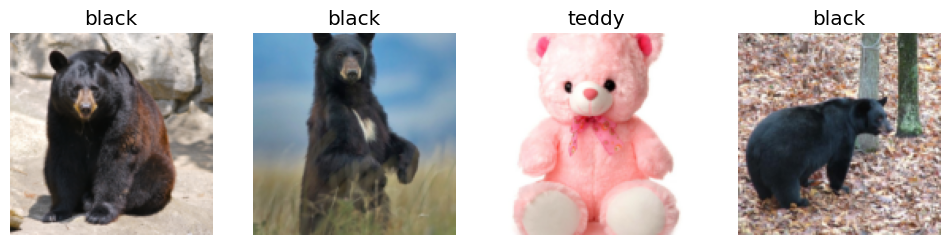

In [26]:
dls.valid.show_batch(max_n=4, nrows=1)

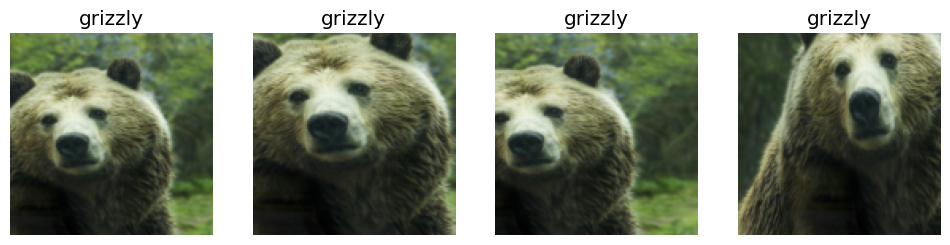

In [27]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

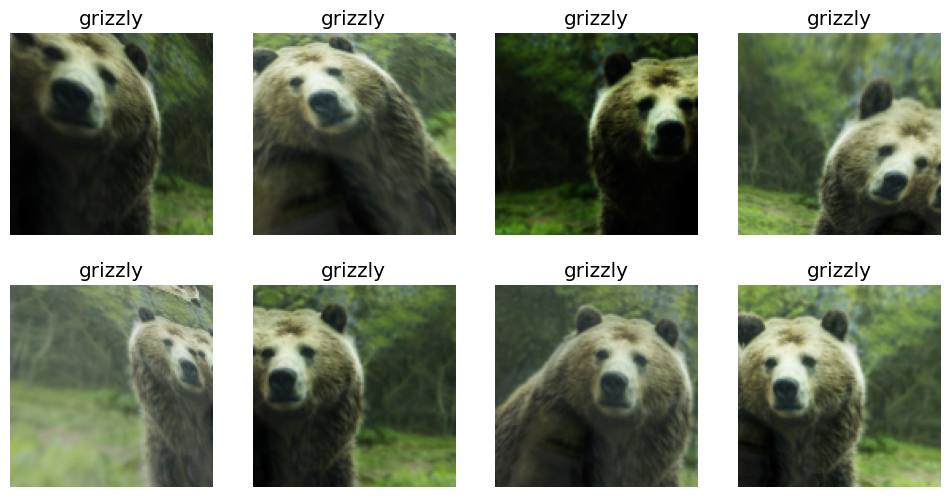

In [28]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

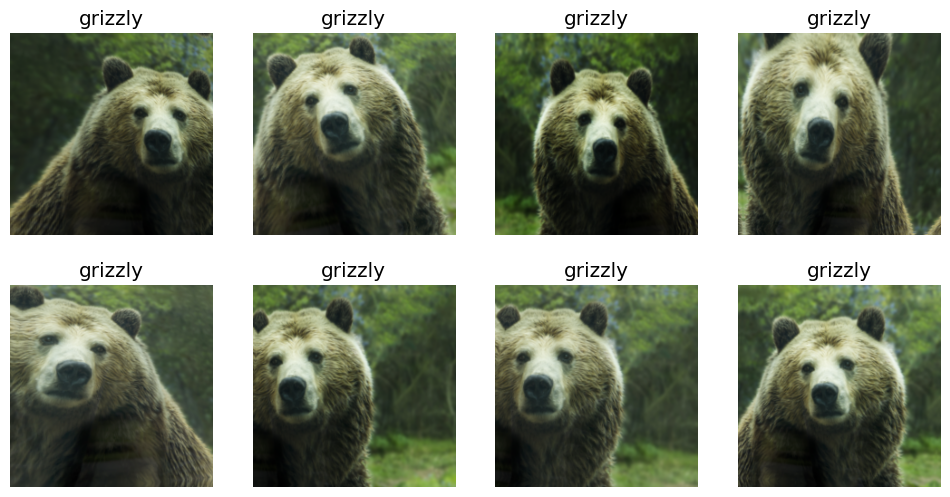

In [29]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [30]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

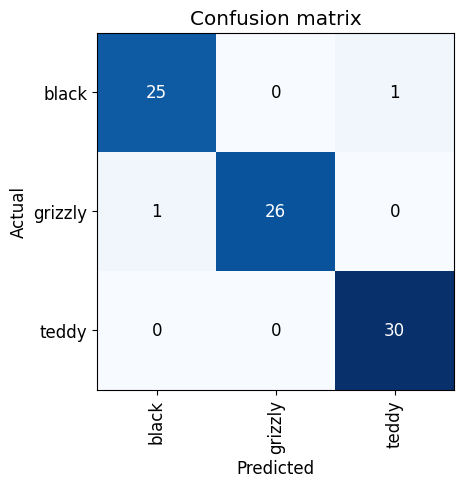

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

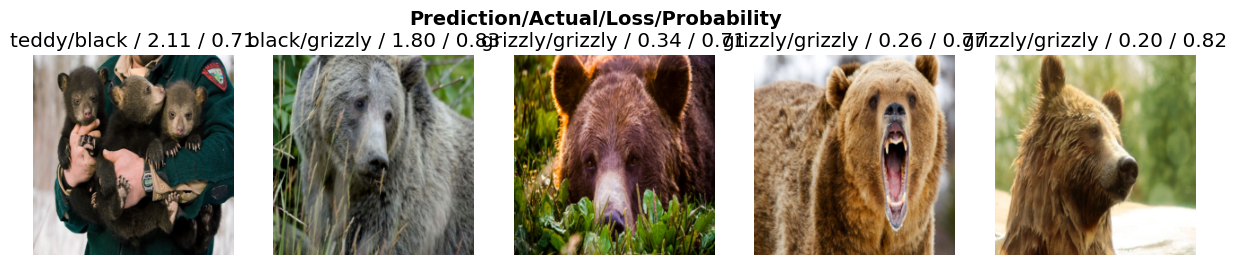

In [32]:
interp.plot_top_losses(5, nrows=1)
